In [ ]:
# default_exp modeling.core

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.core

> This module contains core custom models, loss functions, and a default layer group splitter for use in applying discriminiative learning rates to your huggingface models trained via fastai

In [ ]:
#export
import torch, nlp
from transformers import *

from fastai.text.all import *
from fastai.callback.hook import _print_shapes

from blurr.utils import *
from blurr.data.core import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Base splitter, model wrapper, and model callback

In [ ]:
#export
def hf_splitter(m):
    """Splits the huggingface model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, 'hf_model')) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]
    
    groups = L([ m for m_name, m in list(top_module.named_children()) ])
    groups += L([ m for m_name, m in root_modules[1:] ])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
show_doc(hf_splitter)

<h4 id="hf_splitter" class="doc_header"><code>hf_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>hf_splitter</code>(**`m`**)

Splits the huggingface model based on various model architecture conventions

In [ ]:
#export
class HF_BaseModelWrapper(Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        
        n_fwd_args = self.hf_model.forward.__code__.co_argcount
        self.hf_model_fwd_args = self.hf_model.forward.__code__.co_varnames[:n_fwd_args][1:]
        
    def forward(self, x): 
        for k in list(x): 
            if k not in self.hf_model_fwd_args: del x[k]         
                
        return self.hf_model(**x)

Note that `HF_baseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

In [ ]:
#export
class HF_BaseModelCallback(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

We use a `Callback` for handling what is returned from the huggingface model ... "the huggingface model will return a tuple in outputs, with the actual predictions and some additional activations (should we want to use them is some regularization scheme)" - from the fastai [Transformer's Tutorial](http://dev.fast.ai/tutorial.transformers)

## Sequence classification

Below demonstrates how to setup your `blurr` pipeline for a sequence classification task (e.g., a model that requires a single text input)

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
imdb_df = pd.read_csv(path/'texts.csv')

In [ ]:
imdb_df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [ ]:
#hide_output
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "roberta-base" # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, task=task)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [ ]:
# single input
blocks = (HF_TextBlock(hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), CategoryBlock)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'), 
                   get_y=ColReader('label'), 
                   splitter=ColSplitter(col='is_valid'))

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,category
0,"Raising Victor Vargas: A Review<br /><br />You know, Raising Victor Vargas is like sticking your hands into a big, steaming bowl of oatmeal. It's warm and gooey, but you're not sure if it feels right. Try as I might, no matter how warm and gooey Raising Victor Vargas became I was always aware that something didn't quite feel right. Victor Vargas suffers from a certain overconfidence on the director's part. Apparently, the director thought that the ethnic backdrop of a Latino family on the lower east side, and an idyllic storyline would make the film critic proof. He was right, but it didn't fool me. Raising Victor Vargas is the story about a seventeen-year old boy called, you guessed it, Victor Vargas (Victor Rasuk) who lives his teenage years chasing more skirt than the Rolling Stones could do in all the years they've toured. The movie starts off in `Ugly Fat' Donna's bedroom where Victor is sure to seduce her, but a cry from outside disrupts his plans when his best-friend Harold (Kevin Rivera) comes-a-looking for him. Caught in the attempt by Harold and his sister, Victor Vargas runs off for damage control. Yet even with the embarrassing implication that he's been boffing the homeliest girl in the neighborhood, nothing dissuades young Victor from going off on the hunt for more fresh meat. On a hot, New York City day they make way to the local public swimming pool where Victor's eyes catch a glimpse of the lovely young nymph Judy (Judy Marte), who's not just pretty, but a strong and independent too. The relationship that develops between Victor and Judy becomes the focus of the film. The story also focuses on Victor's family that is comprised of his grandmother or abuelita (Altagracia Guzman), his brother Nino (also played by real life brother to Victor, Silvestre Rasuk) and his sister Vicky (Krystal Rodriguez). The action follows Victor between scenes with Judy and scenes with his family. Victor tries to cope with being an oversexed pimp-daddy, his feelings for Judy and his grandmother's conservative Catholic upbringing.<br /><br />The problems that arise from Raising Victor Vargas are a few, but glaring errors. Throughout the film you get to know certain characters like Vicky, Nino, Grandma,",negative
1,"THE SHOP AROUND THE CORNER is one of the sweetest and most feel-good romantic comedies ever made. There's just no getting around that, and it's hard to actually put one's feeling for this film into words. It's not one of those films that tries too hard, nor does it come up with the oddest possible scenarios to get the two protagonists together in the end. In fact, all its charm is innate, contained within the characters and the setting and the plot... which is highly believable to boot. It's easy to think that such a love story, as beautiful as any other ever told, *could* happen to you... a feeling you don't often get from other romantic comedies, however sweet and heart-warming they may be. <br /><br />Alfred Kralik (James Stewart) and Clara Novak (Margaret Sullavan) don't have the most auspicious of first meetings when she arrives in the shop (Matuschek & Co.) he's been working in for the past nine years, asking for a job. They clash from the very beginning, mostly over a cigarette box that plays music when it's opened--he thinks it's a ludicrous idea; she makes one big sell of it and gets hired. Their bickering takes them through the next six months, even as they both (unconsciously, of course!) fall in love with each other when they share their souls and minds in letters passed through PO Box 237. This would be a pretty thin plotline to base an entire film on, except that THE SHOP AROUND THE CORNER is expertly fleshed-out with a brilliant supporting cast made up of entirely engaging characters, from the fatherly but lonely Hugo Matuschek (Frank Morgan) himself, who learns that his shop really is his home; Pirovitch (Felix Bressart), Kralik's sidekick and friend who always skitters out of the room when

### Training

We'll also add in custom summary methods for blurr learners/models that work with dictionary inputs

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

`.to_fp16()` requires a GPU so had to remove for tests to run on github.  Let's check that we can get predictions.

In [ ]:
b = dls.one_batch()

In [ ]:
learn.model(b[0])

(tensor([[0.0173, 0.0322],
         [0.0076, 0.0268],
         [0.0125, 0.0255],
         [0.0141, 0.0351]], device='cuda:1', grad_fn=<AddmmBackward>),)

In [ ]:
#export
def blurr_module_summary(learn, *xb):
    "Print a summary of `model` using `xb`"
    infos = layer_info(learn, *xb)
    n,bs = 64,find_bs(xb)
    inp_sz = _print_shapes(apply(lambda x:x.shape,  xb[0]['input_ids']), bs)
    res = f"{learn.model.__class__.__name__} (Input shape: {inp_sz})\n"
    res += "=" * n + "\n"
    res += f"{'Layer (type)':<20} {'Output Shape':<20} {'Param #':<10} {'Trainable':<10}\n"
    res += "=" * n + "\n"
    ps,trn_ps = 0,0
    infos = [o for o in infos if o is not None] #see comment in previous cell
    for typ,np,trn,sz in infos:
        if sz is None: continue
        ps += np
        if trn: trn_ps += np
        res += f"{typ:<20} {_print_shapes(sz, bs)[:19]:<20} {np:<10,} {str(trn):<10}\n"
        res += "_" * n + "\n"
    res += f"\nTotal params: {ps:,}\n"
    res += f"Total trainable params: {trn_ps:,}\n"
    res += f"Total non-trainable params: {ps - trn_ps:,}\n\n"
    return PrettyString(res)

In [ ]:
#export
@patch
def blurr_summary(self:Learner):
    "Print a summary of the model, optimizer and loss function."
    xb = self.dls.train.one_batch()[:self.dls.train.n_inp]
    res = blurr_module_summary(self, *xb)
    res += f"Optimizer used: {self.opt_func}\nLoss function: {self.loss_func}\n\n"
    if self.opt is not None:
        res += f"Model " + ("unfrozen\n\n" if self.opt.frozen_idx==0 else f"frozen up to parameter group #{self.opt.frozen_idx}\n\n")
    res += "Callbacks:\n" + '\n'.join(f"  - {cb}" for cb in sort_by_run(self.cbs))
    return PrettyString(res)

We have to create our own `summary` methods above because fastai only works where things are represented by a *single tensor*.  But in the case of huggingface transformers, a *single* sequence is represented by *multiple tensors* (in a dictionary).  

The change to make this work is so minor I think that the fastai library can/will hopefully be updated to support this use case.

In [ ]:
# learn.blurr_summary()

In [ ]:
print(len(learn.opt.param_groups))

4


SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=0.03981071710586548)

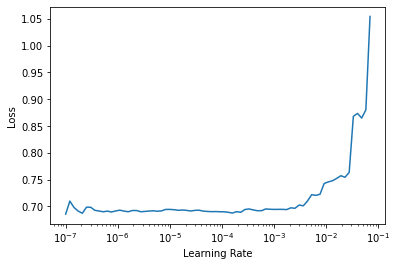

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.290000,0.270782,0.900000,00:21


### Showing results

And here we creat a @typedispatched impelmentation of `Learner.show_results`.

In [ ]:
#export
@typedispatch
def show_results(x:HF_BaseInput, y, samples, outs, learner, ctxs=None, max_n=6, **kwargs):        
    kwargs['hf_tokenizer'] = learner.dls.before_batch[0].hf_tokenizer
    
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
    ctxs = show_batch[object](x, y, samples, max_n=max_n, ctxs=ctxs, **kwargs)
    
    n_preds_per_input = len(outs[0])
    if (n_preds_per_input == 1): 
        for i,ctx in enumerate(ctxs): ctx['target'] = outs[i][0]
    else:
        for pred_idx in range(n_preds_per_input):
            for i,ctx in enumerate(ctxs):  ctx[f'target{pred_idx+1}'] = outs[i][pred_idx]

    display_df(pd.DataFrame(ctxs))
    return ctxs

In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geisha filtered through their own ignorance and misconceptions. So what is this movie if it isn't about Japan or geisha? Is it pure fantasy as so many people have said? Yes, but then why make it into an American fantasy?<br /><br />There were so many missed opportunities. Imagine a culture where there are no puritanical hang-ups, no connotations of sin about sex. Sex is natural and normal. How is sex handled in this movie? Right. Like it was dirty. The closest thing to a sex scene in the movie has Sayuri wrinkling up her nose and grimacing with distaste for five seconds as if the man trying to mount her had dropped a handful of cockroaches on her crotch. <br /><br />Does anyone actually enjoy sex in this movie? Nope. One character is said to be promiscuous but all we see is her pushing away her lover because it looks like she doesn't want to get caught doing something dirty. Such typical American puritanism has no place in a movie about Japanese geisha.<br /><br />Did Sayuri enjoy her first ravishing by some old codger after her cherry was auctioned off? Nope. She lies there like a cold slab of meat on a chopping block. Of course she isn't supposed to enjoy it. And that is what I mean about this movie. Why couldn't they have given her something to enjoy? Why does all the sex have to be sinful and wrong?<br /><br />Behind Mameha the Chairman was Sayuri's secret patron, and as such he was behind the auction of her virginity. He could have rigged the auction and won her himself. Nobu didn't even bid. So why did the Chairman let that old codger win her and, reeking of old-man stink, get his fingers all over her naked body? Would any woman ever really forgive a man for that?<br /><br />Let's",negative,negative
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I have not read Hickam's memoirs, but I am still able to enjoy and understand their film adaptation. The film, directed by Joe Johnston and written by Lewis Colick, records the story of teenager Homer Hickam (Jake Gyllenhaal), beginning in October of 1957. It opens with the sound of a radio broadcast, bringing news of the Russian satellite Sputnik, the first artificial satellite in orbit. We see a images of a blue-gray town and its people: mostly miners working for the Olga Coal Company. One of the miners listens to the news on a hand-held radio as he enters the elevator shaft, but the signal is lost as he disappears into the darkness, losing sight of the starry sky above him. A melancholy violin tune fades with this image. We then get a jolt of Elvis on a car radio as words on the screen inform us of the setting: October 5, 1957, Coalwood, West Virginia. Homer and his buddies, Roy Lee Cook (William Lee Scott) and Sherman O'Dell (Chad Lindberg), are talking about football tryouts. Football scholarships are the only way out of the town, and working in the mines, for these boys. ""Why are the jocks the only ones who get to go to college,"" questions Homer. Roy Lee replies, ""They're also the only ones who get the girls."" Homer doesn't make it in football like his older brother, so he is destined for the mines, and to follow in his father's footsteps as mine foreman. Until he sees the dot of light streaking across the October sky. Then he wants to build a rocket. ""I want

In [ ]:
#export
@patch
def blurr_predict(self:Learner, item, rm_type_tfms=None, with_input=False):
    dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
    
    # this is where we have to change things up since a blurr "input" is represented by a dictionary of
    # tensors (input_ids, attention_mask, token_type_ids, etc...) and not a single tensor (which fastai assumes
    # in a number of places)
    b = dl.one_batch()
    inp = b[0]
    preds, _, dec_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)
    
    i = getattr(self.dls, 'n_inp', -1)
    inp = (inp,) if i==1 else tuplify(inp)
    dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
    dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
    res = dec_targ,dec_preds[0],preds[0]
    if with_input: res = (dec_inp,) + res
    return res

Same as with `summary`, we need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
learn.blurr_predict('I really liked the movie')

('positive', tensor(1), tensor([0.0763, 0.9237]))

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.184161,0.222415,0.920000,00:34
1,0.167082,0.214611,0.920000,00:33
2,0.144612,0.213530,0.925000,00:34


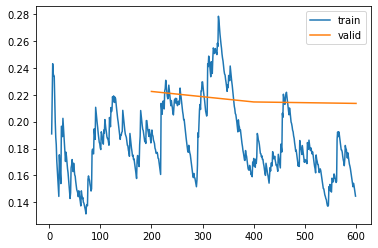

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geisha filtered through their own ignorance and misconceptions. So what is this movie if it isn't about Japan or geisha? Is it pure fantasy as so many people have said? Yes, but then why make it into an American fantasy?<br /><br />There were so many missed opportunities. Imagine a culture where there are no puritanical hang-ups, no connotations of sin about sex. Sex is natural and normal. How is sex handled in this movie? Right. Like it was dirty. The closest thing to a sex scene in the movie has Sayuri wrinkling up her nose and grimacing with distaste for five seconds as if the man trying to mount her had dropped a handful of cockroaches on her crotch. <br /><br />Does anyone actually enjoy sex in this movie? Nope. One character is said to be promiscuous but all we see is her pushing away her lover because it looks like she doesn't want to get caught doing something dirty. Such typical American puritanism has no place in a movie about Japanese geisha.<br /><br />Did Sayuri enjoy her first ravishing by some old codger after her cherry was auctioned off? Nope. She lies there like a cold slab of meat on a chopping block. Of course she isn't supposed to enjoy it. And that is what I mean about this movie. Why couldn't they have given her something to enjoy? Why does all the sex have to be sinful and wrong?<br /><br />Behind Mameha the Chairman was Sayuri's secret patron, and as such he was behind the auction of her virginity. He could have rigged the auction and won her himself. Nobu didn't even bid. So why did the Chairman let that old codger win her and, reeking of old-man stink, get his fingers all over her naked body? Would any woman ever really forgive a man for that?<br /><br />Let's",negative,negative
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I have not read Hickam's memoirs, but I am still able to enjoy and understand their film adaptation. The film, directed by Joe Johnston and written by Lewis Colick, records the story of teenager Homer Hickam (Jake Gyllenhaal), beginning in October of 1957. It opens with the sound of a radio broadcast, bringing news of the Russian satellite Sputnik, the first artificial satellite in orbit. We see a images of a blue-gray town and its people: mostly miners working for the Olga Coal Company. One of the miners listens to the news on a hand-held radio as he enters the elevator shaft, but the signal is lost as he disappears into the darkness, losing sight of the starry sky above him. A melancholy violin tune fades with this image. We then get a jolt of Elvis on a car radio as words on the screen inform us of the setting: October 5, 1957, Coalwood, West Virginia. Homer and his buddies, Roy Lee Cook (William Lee Scott) and Sherman O'Dell (Chad Lindberg), are talking about football tryouts. Football scholarships are the only way out of the town, and working in the mines, for these boys. ""Why are the jocks the only ones who get to go to college,"" questions Homer. Roy Lee replies, ""They're also the only ones who get the girls."" Homer doesn't make it in football like his older brother, so he is destined for the mines, and to follow in his father's footsteps as mine foreman. Until he sees the dot of light streaking across the October sky. Then he wants to build a rocket. ""I want

In [ ]:
learn.blurr_predict("This was a really good movie")

('positive', tensor(1), tensor([0.1387, 0.8613]))

In [ ]:
learn.blurr_predict("Acting was so bad it was almost funny.")

('negative', tensor(0), tensor([0.9001, 0.0999]))

### Inference

In [ ]:
learn.export(fname='seq_class_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='seq_class_learn_export.pkl')
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")

('negative', tensor(0), tensor([0.8242, 0.1758]))

## Tests

The tests below to ensure the core training code above works for **all** pretrained sequence classification models available in huggingface.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
BLURR_MODEL_HELPER.get_models(task='SequenceClassification')

[transformers.modeling_albert.AlbertForSequenceClassification,
 transformers.modeling_auto.AutoModelForSequenceClassification,
 transformers.modeling_bart.BartForSequenceClassification,
 transformers.modeling_bert.BertForSequenceClassification,
 transformers.modeling_camembert.CamembertForSequenceClassification,
 transformers.modeling_distilbert.DistilBertForSequenceClassification,
 transformers.modeling_electra.ElectraForSequenceClassification,
 transformers.modeling_flaubert.FlaubertForSequenceClassification,
 transformers.modeling_longformer.LongformerForSequenceClassification,
 transformers.modeling_mobilebert.MobileBertForSequenceClassification,
 transformers.modeling_reformer.ReformerForSequenceClassification,
 transformers.modeling_roberta.RobertaForSequenceClassification,
 transformers.modeling_xlm.XLMForSequenceClassification,
 transformers.modeling_xlm_roberta.XLMRobertaForSequenceClassification,
 transformers.modeling_xlnet.XLNetForSequenceClassification]

In [ ]:
pretrained_model_names = [
    'albert-base-v1',
    'facebook/bart-base',
    'bert-base-uncased',
    'camembert-base',
    'distilbert-base-uncased',
    'monologg/electra-small-finetuned-imdb',
    'flaubert/flaubert_small_cased', 
    'allenai/longformer-base-4096',
    'google/mobilebert-uncased',
    'roberta-base',
    'xlm-mlm-en-2048',
    'xlm-roberta-base',
    'xlnet-base-cased'
]

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)

model_path = Path('models')
imdb_df = pd.read_csv(path/'texts.csv')

In [ ]:
#slow
#hide_output
task = HF_TASKS_AUTO.SequenceClassification
bsz = 2
seq_sz = 128

test_results = []
for model_name in pretrained_model_names:
    error=None
    
    print(f'=== {model_name} ===\n')
    
    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(model_name, 
                                                                                   task=task, 
                                                                                   config_kwargs={'num_labels': 2})
    
    print(f'architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n')

    blocks = (HF_TextBlock(hf_arch=hf_arch, hf_tokenizer=hf_tokenizer, max_length=seq_sz, padding='max_length'), 
              CategoryBlock)

    dblock = DataBlock(blocks=blocks, 
                       get_x=ColReader('text'), 
                       get_y=ColReader('label'), 
                       splitter=ColSplitter(col='is_valid'))
    
    dls = dblock.dataloaders(imdb_df, bs=bsz)
    
    model = HF_BaseModelWrapper(hf_model)
    learn = Learner(dls, 
                    model,
                    opt_func=partial(Adam),
                    loss_func=CrossEntropyLossFlat(),
                    metrics=[accuracy],
                    cbs=[HF_BaseModelCallback],
                    splitter=hf_splitter)

    learn.create_opt()             # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    b = dls.one_batch()
    
    try:
        print('*** TESTING DataLoaders ***')
        test_eq(len(b), bsz)
        test_eq(len(b[0]['input_ids']), bsz)
        test_eq(b[0]['input_ids'].shape, torch.Size([bsz, seq_sz]))
        test_eq(len(b[1]), bsz)

        print('*** TESTING One pass through the model ***')
        preds = learn.model(b[0])
        test_eq(len(preds[0]), bsz)
        test_eq(preds[0].shape, torch.Size([bsz, 2]))

        print('*** TESTING Training/Results ***')
        learn.fit_one_cycle(1, lr_max=1e-3)

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'PASSED', ''))
        learn.show_results(learner=learn, max_n=2)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'FAILED', err))
    finally:
        # cleanup
        del learn; torch.cuda.empty_cache()

=== albert-base-v1 ===



Some weights of the model checkpoint at albert-base-v1 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

architecture:	albert
tokenizer:	AlbertTokenizer
model:		AlbertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.611063,0.641270,0.635000,00:16


,text,category,target
0,"the trouble with the book, ""memoirs of a geisha"" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from japanese ways of thinking were the characters.br /br /the movie isn't about japan or real geisha. it is a story about a few american men's mistaken ideas about japan and geisha filtered through their own ignorance and misconceptions",negative,negative
1,"how viewers react to this new ""adaption"" of shirley jackson's book, which was promoted as not being a remake of the original 1963 movie (true enough), will be based, i suspect, on the following: those who were big fans of either the book or original movie are not going to think much of this one...and those who have never been exposed to either, and who are big fans of hollywood's current trend towards ""special effects"" being the first and last word in how ""good"" a film is, are going to love it.br /",negative,positive


=== facebook/bart-base ===



Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartForSequenceClassification: ['final_logits_bias']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to u

architecture:	bart
tokenizer:	BartTokenizer
model:		BartForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.261993,0.502456,0.800000,00:22


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geisha filtered through their own ignorance and misconceptions. So what is this movie if it isn't",negative,negative
1,"To review this movie, I without any doubt would have to quote that memorable scene in Tarantino's ""Pulp Fiction"" (1994) when Jules and Vincent are talking about Mia Wallace and what she does for a living. Jules tells Vincent that the ""Only thing she did worthwhile was pilot"". Vincent asks ""What the hell is a pilot?"" and Jules goes into a very well description of what a TV pilot is: ""Well, the way they make shows is, they make one show. That show's called a 'pilot'. Then they show that show to the people who make shows, and on the",negative,negative


=== bert-base-uncased ===



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

architecture:	bert
tokenizer:	BertTokenizer
model:		BertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.495689,0.509857,0.770000,00:18


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those far from japanese ways of thinking were the characters. < br / > < br / > the movie isn't about japan or real geisha. it is a story about a few american men's mistaken ideas about japan and geisha filtered through their own ignorance and misconceptions. so what is this movie",negative,negative
1,"bonanza had a great cast of wonderful actors. lorne greene, pernell whitaker, michael landon, dan blocker, and even guy williams ( as the cousin who was brought in for several episodes during 1964 to replace adam when he was leaving the series ). the cast had chemistry, and they seemed to genuinely like each other. that made many of their weakest stories work a lot better than they should have. it also made many of their best stories into great western drama. < br / > < br / > like any show that was shooting over thirty episodes every season, there are bound to be some weak ones.",positive,positive


=== camembert-base ===



Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'cl

architecture:	camembert
tokenizer:	CamembertTokenizer
model:		CamembertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.701792,0.681229,0.535000,00:19


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a",negative,negative
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I have not read Hickam's memoirs, but I am still able to enjoy and understand their film adaptation. The film, directed",positive,negative


=== distilbert-base-uncased ===



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

architecture:	distilbert
tokenizer:	DistilBertTokenizer
model:		DistilBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.409663,0.484916,0.780000,00:12


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those far from japanese ways of thinking were the characters. < br / > < br / > the movie isn't about japan or real geisha. it is a story about a few american men's mistaken ideas about japan and geisha filtered through their own ignorance and misconceptions. so what is this movie",negative,negative
1,"to review this movie, i without any doubt would have to quote that memorable scene in tarantino's "" pulp fiction "" ( 1994 ) when jules and vincent are talking about mia wallace and what she does for a living. jules tells vincent that the "" only thing she did worthwhile was pilot "". vincent asks "" what the hell is a pilot? "" and jules goes into a very well description of what a tv pilot is : "" well, the way they make shows is, they make one show. that show's called a'pilot '. then they show that show to the people who make shows, and on",negative,positive


=== monologg/electra-small-finetuned-imdb ===



Some weights of the model checkpoint at monologg/electra-small-finetuned-imdb were not used when initializing ElectraForSequenceClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/electra-small-finetuned-imdb and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a

architecture:	electra
tokenizer:	ElectraTokenizer
model:		ElectraForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.288960,0.307748,0.855000,00:18


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those far from japanese ways of thinking were the characters. < br / > < br / > the movie isn't about japan or real geisha. it is a story about a few american men's mistaken ideas about japan and geisha filtered through their own ignorance and misconceptions. so what is this movie",negative,positive
1,"how viewers react to this new "" adaption "" of shirley jackson's book, which was promoted as not being a remake of the original 1963 movie ( true enough ), will be based, i suspect, on the following : those who were big fans of either the book or original movie are not going to think much of this one... and those who have never been exposed to either, and who are big fans of hollywood's current trend towards "" special effects "" being the first and last word in how "" good "" a film is, are going to love it. < br / > < br / > things",negative,negative


=== flaubert/flaubert_small_cased ===



Some weights of the model checkpoint at flaubert/flaubert_small_cased were not used when initializing FlaubertForSequenceClassification: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_small_cased and are newly initialized: ['transformer.position_ids', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream tas

architecture:	flaubert
tokenizer:	FlaubertTokenizer
model:		FlaubertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.757368,0.701342,0.495000,00:12


,text,category,target
0,"The trouble with the book, "" Memoirs of a Geisha "" is that it had Japanese surfaces but underneath the surfaces it was all an American man' s way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters. < br / > < br / > The movie isn' t about Japan or real geisha. It is a story about",negative,positive
1,"< br / > < br / > I' m sure things didn' t exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie "" October Sky "" ( an anagram of the book' s title ) is good enough to stand alone. I have not read Hickam' s memoirs, but I am still able to enjoy and understand their film adaptation. The film, directed by Joe Johnston and written by Lewis Coli",positive,negative


=== allenai/longformer-base-4096 ===



Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', '

architecture:	longformer
tokenizer:	LongformerTokenizer
model:		LongformerForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.548809,0.566221,0.750000,01:58


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geisha filtered through their own ignorance and misconceptions. So what is this movie if it isn't",negative,positive
1,"To review this movie, I without any doubt would have to quote that memorable scene in Tarantino's ""Pulp Fiction"" (1994) when Jules and Vincent are talking about Mia Wallace and what she does for a living. Jules tells Vincent that the ""Only thing she did worthwhile was pilot"". Vincent asks ""What the hell is a pilot?"" and Jules goes into a very well description of what a TV pilot is: ""Well, the way they make shows is, they make one show. That show's called a 'pilot'. Then they show that show to the people who make shows, and on the",negative,negative


=== google/mobilebert-uncased ===



Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MobileBertForSequence

architecture:	mobilebert
tokenizer:	MobileBertTokenizer
model:		MobileBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,175575.375000,6483.053711,0.540000,00:22


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those far from japanese ways of thinking were the characters. < br / > < br / > the movie isn't about japan or real geisha. it is a story about a few american men's mistaken ideas about japan and geisha filtered through their own ignorance and misconceptions. so what is this movie",negative,negative
1,"to review this movie, i without any doubt would have to quote that memorable scene in tarantino's "" pulp fiction "" ( 1994 ) when jules and vincent are talking about mia wallace and what she does for a living. jules tells vincent that the "" only thing she did worthwhile was pilot "". vincent asks "" what the hell is a pilot? "" and jules goes into a very well description of what a tv pilot is : "" well, the way they make shows is, they make one show. that show's called a'pilot '. then they show that show to the people who make shows, and on",negative,negative


=== roberta-base ===



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

architecture:	roberta
tokenizer:	RobertaTokenizer
model:		RobertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.423652,0.424624,0.805000,00:18


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geisha filtered through their own ignorance and misconceptions. So what is this movie if it isn't",negative,negative
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I have not read Hickam's memoirs, but I am still able to enjoy and understand their film adaptation. The film, directed by Joe Johnston and written by Lewis Colick, records the story of teenager Homer Hickam (Jake Gyllenhaal), beginning in October of 1957. It opens with the",positive,positive


=== xlm-mlm-en-2048 ===



Some weights of the model checkpoint at xlm-mlm-en-2048 were not used when initializing XLMForSequenceClassification: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing XLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMForSequenceClassification were not initialized from the model checkpoint at xlm-mlm-en-2048 and are newly initialized: ['transformer.position_ids', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

architecture:	xlm
tokenizer:	XLMTokenizer
model:		XLMForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.939309,0.695867,0.465000,00:47


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from japanese ways of thinking were the characters. < br / > < br / > the movie isn 't about japan or real geisha. it is a story about a few american men's mistaken ideas about japan and geisha filtered through their own ignorance and misconceptions. so what is this movie if",negative,positive
1,"how viewers react to this new "" adaption "" of shirley jackson's book, which was promoted as not being a remake of the original 1963 movie ( true enough ), will be based, i suspect, on the following : those who were big fans of either the book or original movie are not going to think much of this one... and those who have never been exposed to either, and who are big fans of hollywood's current trend towards "" special effects "" being the first and last word in how "" good "" a film is, are going to love it. < br / > < br / > things i did not like",negative,positive


=== xlm-roberta-base ===



Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weig

architecture:	xlm_roberta
tokenizer:	XLMRobertaTokenizer
model:		XLMRobertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.681772,0.682475,0.590000,00:19


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geisha filtered",negative,negative
1,"To review this movie, I without any doubt would have to quote that memorable scene in Tarantino's ""Pulp Fiction"" (1994) when Jules and Vincent are talking about Mia Wallace and what she does for a living. Jules tells Vincent that the ""Only thing she did worthwhile was pilot"". Vincent asks ""What the hell is a pilot?"" and Jules goes into a very well description of what a TV pilot is: ""Well, the way they make shows is, they make one show. That show's called a 'pilot'. Then they show that show to the people",negative,negative


=== xlnet-base-cased ===



/home/wgilliam/anaconda3/envs/blurr/lib/python3.7/site-packages/transformers/configuration_xlnet.py:211: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `men_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are i

architecture:	xlnet
tokenizer:	XLNetTokenizer
model:		XLNetForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


/home/wgilliam/anaconda3/envs/blurr/lib/python3.7/site-packages/transformers/modeling_xlnet.py:304: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  attn_score = (ac + bd + ef) * self.scale


epoch,train_loss,valid_loss,accuracy,time
0,0.594473,0.562078,0.740000,00:26


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geisha filtered through their own ignorance and",negative,negative
1,"To review this movie, I without any doubt would have to quote that memorable scene in Tarantino's ""Pulp Fiction"" (1994) when Jules and Vincent are talking about Mia Wallace and what she does for a living. Jules tells Vincent that the ""Only thing she did worthwhile was pilot"". Vincent asks ""What the hell is a pilot?"" and Jules goes into a very well description of what a TV pilot is: ""Well, the way they make shows is, they make one show. That show's called a 'pilot'. Then they show that show to",negative,positive


In [ ]:
#slow
#hide_input
test_results_df = pd.DataFrame(test_results, columns=['arch', 'tokenizer', 'model', 'result', 'error'])
display_df(test_results_df)

,arch,tokenizer,model,result,error
0,albert,AlbertTokenizer,AlbertForSequenceClassification,PASSED,
1,bart,BartTokenizer,BartForSequenceClassification,PASSED,
2,bert,BertTokenizer,BertForSequenceClassification,PASSED,
3,camembert,CamembertTokenizer,CamembertForSequenceClassification,PASSED,
4,distilbert,DistilBertTokenizer,DistilBertForSequenceClassification,PASSED,
5,electra,ElectraTokenizer,ElectraForSequenceClassification,PASSED,
6,flaubert,FlaubertTokenizer,FlaubertForSequenceClassification,PASSED,
7,longformer,LongformerTokenizer,LongformerForSequenceClassification,PASSED,
8,mobilebert,MobileBertTokenizer,MobileBertForSequenceClassification,PASSED,
9,roberta,RobertaTokenizer,RobertaForSequenceClassification,PASSED,


## Example: Multi-label classification

Below demonstrates how to setup your `blurr` pipeline for a multi-label classification task

In [ ]:
# creates a dataset with the first 10% of training set
raw_data = nlp.load_dataset('civil_comments', split='train[:1%]') 
len(raw_data)

Using custom data configuration default


18049

In [ ]:
toxic_df = pd.DataFrame(raw_data, columns=list(raw_data.features.keys()))
toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


In [ ]:
lbl_cols = list(toxic_df.columns[2:]); lbl_cols

['severe_toxicity',
 'obscene',
 'threat',
 'insult',
 'identity_attack',
 'sexual_explicit']

In [ ]:
toxic_df = toxic_df.round({col: 0 for col in lbl_cols})
toxic_df = toxic_df.convert_dtypes()

toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0,0,0,0,0,0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0,0,0,0,0,0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0,0,0,0,0,0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0,0,0,0,0,0
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0,0


In [ ]:
#hide_output
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "roberta-base" # "distilbert-base-uncased" "bert-base-uncased"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(lbl_cols)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Note how we have to configure the `num_labels` to the number of labels we are predicting. Given that our labels are already encoded, we use a `MultiCategoryBlock` with `encoded=True` and `vocab` equal to the columns with our 1's and 0's.

In [ ]:
# single input
blocks = (
    HF_TextBlock(hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), 
    MultiCategoryBlock(encoded=True, vocab=lbl_cols)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'), get_y=ColReader(lbl_cols), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(toxic_df, bs=4)

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([4, 404]), torch.Size([4, 6]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,None
0,"As usual WW plumbing the depths for deeper meaning... that is unless it involves an issue on which they disagree then it is ridicule 24/7. Clever creating the Bundyland series complete with cartoon banner. Set the tone for the level of journalism to expect... journalism? ... fatastisticism. \n\nI did notice you soft pedaling the ridicule of David Fry identifying him as troubled. My guess is that has more to do with sympathy for his pot smoking withdrawl rants than respect for his politics. Respect is never a factor with liberals as evidenced by your series of vapid caricatures. \n\nDid you happen to see the stories actual journalists did on Refuge mis-managment, fires, floods, and the millions of Carp that are harassing the birds away from the Bird Refuge? The stories of arbitrary miss-management that are driving unemployment ever higher in eastern Oregon. Curry County Sheriff turning in his badge in frustration for lack of resources dud to dwindling tax base engineered by arbitrary over reaching Federal Government policies. Or how about the thousands of miles of roads proposed to be removed from Oregon wild lands, cutting off public and fire access? What is the one issue the people of Oregon demand universally? Access to the wild lands? You are not reporting that it is being taken away. More closed roads. More illegal Federal Police, guns drawn, stops... as reported by the Sheriff of Grant County. \n\nI suspect the real problem was real people you couldn't care less about were articulate, were actual victims, and made rational arguments you could not respond to. The exact opposite of the great unbathed OWS movement, apart from the paid organizers, that held downtown Portland hostage and trashed 3 park blocks for 3 weeks. \n\nShame on you. You missed some really great stories and even greater people... people who don't drink $5 cups of coffee.",
1,"The lack of 'freedom of speech' to which I referred was the insistence by professors that liberal positons were the 'Truth' incarnate and that anything less than left wing progressivism was anathema and received lower grades on exams. As far as unions, are concerned, there is a field of study over at the Duck U Law School called 'Labor Law' which provides one a lengthy history of the benefits and the downsides of unions in this country. I have to admit that part of my disagreement with unions in Oregon is based on my mandatory membership in SEIU in order to be a State employee. There I saw the union realities of today in the public sector first hand; not the halcyon days of fights against child labor, egregious working conditions etc. Now, the public unions are just different types of Corporations whose purpose is to protect the incompetent and extract further tax dollars to support their liberal agendas. At least real Corporations have to produce something positive to sell.",


In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=BCEWithLogitsLossFlat(),
                metrics=[partial(accuracy_multi, thresh=0.2)],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

learn.loss_func.thresh = 0.2
learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

Since we're doing multi-label classification, we adjust our loss function to use binary cross-entropy and our metrics to use the multi-label friendly version of accuracy.

In [ ]:
preds = model(b[0])
preds[0].shape

torch.Size([4, 6])

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.0014454397605732083)

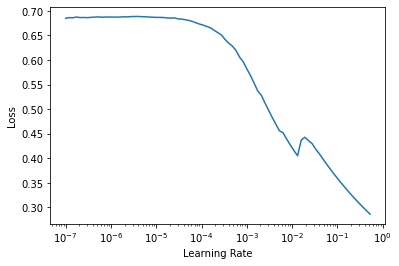

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.036332,0.042089,0.992657,02:55
1,0.044398,0.039479,0.992657,02:57
2,0.033817,0.037818,0.992657,02:57


In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,None,target
0,"Predatory patrol towing isn't a big subject, and there is no advocacy group that is paying any attention to it, but the City of Portland has completely backed off of enforcing state law where the towing predators are operating on private property, and this is Commissioner Novick's failure. He's in charge of towing.\n\nThe City has allowed Retriever Towing to operate in open violation of ADA for years at their NW Quimby lot, and there is absolutely no provision in city ordinance that takes into account when they tow a mobility-disabled person's vehicle. Wheelchair or no wheelchair, the person has to get themselves to the tow yard (which does not have wheelchair access).\n\nLed by Senator Avel Gordly, the legislature enacted important new citizen protections against predatory towing effective January 1, 2008, but there is no effective way for Portlanders to learn what their rights are other than what the predatory towers themselves tell you. A description of the protections has never appeared on the City website. The version posted there has never been correct.\n\nIt is only in the past two years the the City began enforcing the signage requirements, and the City Towing Coordinator worked with the towers to pass the costs onto the citizens. $ 20 of every tow bill goes to the towers to ""compensate"" them for their signs, with no upper limit, and your $ 20 is likely to be paying for signs completely unrelated to the place your vehicle was towed from.\n\nPortland towers are allowed to operate in open violation of state law and the City's own statutes, providing towing services to property owners for free. That is specifically prohibited by state law and City ordinance.\n\nSenator Gordly's legislation was intended to protect people living in apartment complexes, generally low-income, minority populations, and they have no one standing up for them in City Hall. I hope you are that champion.",,[]
1,"To blame Rubio is to find a scapegoat. Trump is a product of many angry, mostly white Americans who now believe their low pay is the result of immigrants, the Chinese, the Mexican government, with a dash of corporate influence. And let's not forget Muslims, who perpetrated what the media dubbed ""the greatest terrorist attack since 9/11 - 14 people killed. No one should rejoice over deaths, the largest attack in 15 years killing 14 shows little threat.\nBefore Trump, Republicans riled over immigration, foreign threats and government control. Spawning a child that ate their mother, the Tea Party came to see Republicans as part of establishment politics. Compromise = bad. This message was spread throughout the land via hate-talk radio and hundreds of right wing wacko web sites (we take Visa) that still spew lies, i.e. our Muslim President, hate for liberals and RINOS. The Heritage Foundation and CATO institute helped craft these arguments\nThen came Trump who spoke ""lies we can believe in"".",,[]


In [ ]:
learn.loss_func.thresh = 0.02

In [ ]:
comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes. 
No enchiladas for them!
"""
learn.blurr_predict(comment)

((#1) ['severe_toxicity'],
 tensor([False, False, False,  True, False, False]),
 tensor([2.0519e-06, 5.5858e-03, 1.1516e-04, 2.7981e-02, 1.8549e-03, 1.1074e-03]))

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-token-classification.ipynb.
Converted 01b_data-question-answering.ipynb.
Converted 01e_data-summarization.ipynb.
Converted 01z_data-language-modeling.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-token-classification.ipynb.
Converted 02b_modeling-question-answering.ipynb.
Converted 02e_modeling-summarization.ipynb.
Converted 02z_modeling-language-modeling.ipynb.
Converted index.ipynb.
